Can use this function if you want to dislpay all rows in dataframe. 
pd.set_option("display.max_rows", None, "display.max_columns", None)

Dataset can be found here: https://www.kaggle.com/arindam235/startup-investments-crunchbase

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

# Checking what type of encoding is used

In [2]:
path='investments_VC.csv'
f = open(path,'rb')
#change to read?
line = f.readline()
print(chardet.detect(line))

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [4]:
dataset = pd.read_csv("investments_VC.csv", encoding = 'unicode_escape')

# Taking a peak at the data

In [18]:
dataset.head(5)

,name,homepage_url,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
0,#waywire,http://www.waywire.com,News,1750000.0,acquired,USA,NY,New York City,New York,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,http://enjoyandtv.com,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,http://www.rockyourpaper.org,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,http://www.InTouchNetwork.com,Electronics,1500000.0,operating,GBR,NaN,London,London,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,NaN,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35244 entries, 0 to 49437
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  35244 non-null  object 
 1   homepage_url          33820 non-null  object 
 2   market                35244 non-null  object 
 3   funding_total_usd     35244 non-null  float64
 4   status                34492 non-null  object 
 5   country_code          35244 non-null  object 
 6   state_code            24450 non-null  object 
 7   region                35244 non-null  object 
 8   city                  34627 non-null  object 
 9   funding_rounds        35244 non-null  float64
 10  founded_year          28884 non-null  float64
 11  first_funding_at      35244 non-null  object 
 12  last_funding_at       35244 non-null  object 
 13  seed                  35244 non-null  float64
 14  venture               35244 non-null  float64
 15  equity_crowdfunding

# Cleaning up data

Converting funding column to float, and removing columns and rows without relevant information to this analysis.

In [5]:
dataset.columns = dataset.columns.str.strip()
dataset["funding_total_usd"] = dataset["funding_total_usd"].str.strip()
dataset['funding_total_usd'] = dataset['funding_total_usd'].str.replace(',','')
dataset['funding_total_usd'] = dataset['funding_total_usd'].replace('-',np.NaN)
dataset['funding_total_usd'] = dataset['funding_total_usd'].astype("float")
#write all in one line?

In [6]:
dataset = dataset[dataset["name"].notnull()]
dataset = dataset[dataset["funding_total_usd"].notnull()]
dataset = dataset[dataset["market"].notnull() & dataset["region"].notnull()]

In [7]:
dataset = dataset.drop(["permalink", "category_list", "founded_quarter", "founded_at", "founded_month"], axis = 1)
dataset = dataset.drop(dataset.loc[:,"round_A":"round_H"], axis = 1)

Validated that total funding adds up other funding columns, remove duplicates.

In [8]:
dataset_manual_fund = dataset.loc[:,"seed":"product_crowdfunding"].sum(axis=1)
manual_not_equal = dataset_manual_fund != dataset['funding_total_usd']

In [147]:
manual_not_equal.value_counts()

False    35244
dtype: int64

In [8]:
dataset.duplicated().sum()

0

# Group companies by funding amount, status, and country

This was one of my earlier projects, but I learned that I could have used a histogram to create these bins. I am working on putting better visualizations in my API project.

In [9]:
ranges = [0, 100000, 1000000, 100000000, 1000000000000]
lables = ["Small startup", "Medium startup", "Large startup", "Established startup"]
value_count_fund = pd.cut(dataset["funding_total_usd"], ranges, labels =lables).value_counts(sort = False)
#check if the cut function duplicates values at the indicated ranges
value_count_status = dataset["status"].value_counts()
value_count_country = dataset["country_code"].copy()
value_count_country = value_count_country.value_counts()
thresh = 500
value_count_country["Other"] = value_count_country[value_count_country < thresh].sum()
value_count_country = value_count_country[value_count_country > thresh]
#value_count_country = value_count_country.value_counts().apply(lambda row:"Other" if row < 100 else row)

In [35]:
value_count_fund

Small startup           4086
Medium startup          8751
Large startup          21447
Established startup      960
Name: funding_total_usd, dtype: int64

In [12]:
value_count_country

USA      23347
GBR       2190
CAN       1123
CHN        964
FRA        718
IND        620
DEU        614
ISR        583
Other     5085
Name: country_code, dtype: int64

# Data Visualization

Text(0.5, 1.0, 'Number of Startups by Funding')

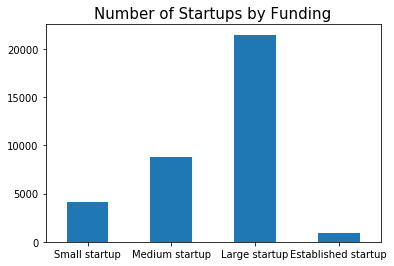

In [56]:
value_count_fund.plot.bar().grid(False)
plt.xticks(rotation = 0)
plt.title("Number of Startups by Funding", fontsize = 15)
#how to remove text...

***
#### Percentile Calculator

In [30]:
funding = 1000000
stats.percentileofscore(dataset['funding_total_usd'], funding, kind = 'weak')

36.42322097378277

or vice versa

In [29]:
percentile = 36.42
np.percentile(dataset['funding_total_usd'], percentile)

1000000.0

***

Text(0.5, 1.0, 'Number of Startups by Status')

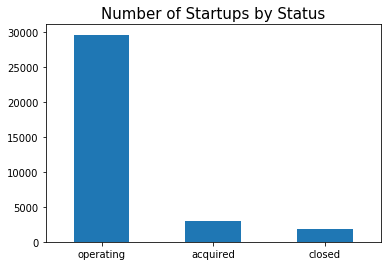

In [54]:
value_count_status.plot.bar().grid(False)
plt.xticks(rotation = 0)
plt.title("Number of Startups by Status", fontsize = 15)

Text(0.5, 1.0, 'Number of Startups by Country')

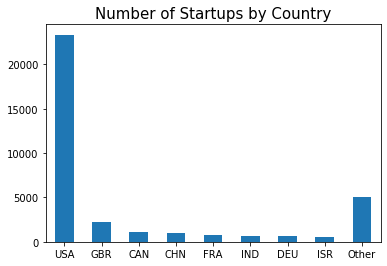

In [53]:
value_count_country.plot.bar().grid(False)
plt.xticks(rotation = 0)
plt.title("Number of Startups by Country", fontsize = 15)

Analysis: As stated in discussion, there seems to be a bias toward largely funded startups in the US that are still operating

Need to sort out dataset into like datatypes before you can graph
plt.figure(figsize=(20,14))
ax = sns.heatmap(dataset, vmin=-1, vmax=1, cbar=False,
                    cmap='RdBu', annot=True)

# Looking at some further analysis(still in progress)

Text(0.5, 1.0, 'Possible Correlations to Funding')

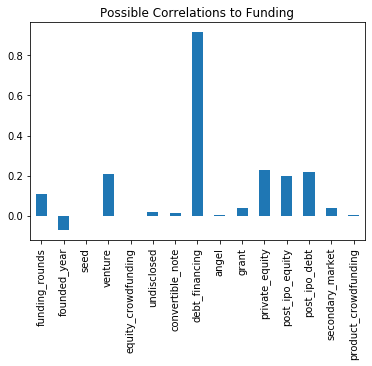

In [52]:
dataset.corr()["funding_total_usd"].iloc[1:].plot.bar()
plt.title("Possible Correlations to Funding")

#### Market Makeup Percentage

In [52]:
market_compare = dataset.groupby("market").agg(np.mean).applymap(lambda x: round(x) if x != null)
#market_compare.reset_index(inplace = True)
#market_compare.sort_values(by = "funding_total_usd", ascending = False).head(20)

SyntaxError: invalid syntax (<ipython-input-52-25df17db6b4e>, line 1)

In [17]:
(dataset["market"].value_counts(normalize = True)*100).head()

 Software          10.835887
 Biotechnology      9.652707
 Mobile             4.344002
 E-Commerce         3.688571
 Curated Web        3.328226
Name: market, dtype: float64

can create interval range with this func "intervals = pd.interval_range(start = 0, end = 600, freq = 60)"

In [18]:
dataset["funding_rounds"].value_counts(bins = 10)

(0.982, 2.7]    27470
(2.7, 4.4]       5669
(4.4, 6.1]       1518
(6.1, 7.8]        247
(7.8, 9.5]        233
(9.5, 11.2]        77
(12.9, 14.6]       12
(11.2, 12.9]       12
(14.6, 16.3]        5
(16.3, 18.0]        1
Name: funding_rounds, dtype: int64

In [20]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

need to clean up market, and do comparison

In [10]:
x = dataset["status"].value_counts()

In [25]:
y = pd.DataFrame(x)
y["frequency"] = (y["status"] / y["status"].sum())*100

In [27]:
y["frequency"].sum()

100.0

In [29]:
dataset["funding_total_usd"].describe()

count    3.524400e+04
mean     1.712770e+07
std      1.782753e+08
min      3.000000e+01
25%      5.000000e+05
50%      2.383737e+06
75%      1.079508e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64